### Read glider data from ERDDAP

**Get Summary**

In [1]:
from erddapy import ERDDAP
import pandas as pd

# Initialize ERDDAP object with the server URL
server_url = "http://slocum-data.marine.rutgers.edu/erddap"
dataset_id = "ru40-20231115T1612-trajectory-raw-rt"

# Create ERDDAP object
e = ERDDAP(server=server_url)

# Set the dataset ID
e.dataset_id = dataset_id

# Retrieve the metadata for the dataset as a pandas DataFrame
info_url = e.get_info_url(response="csv")
info_df = pd.read_csv(info_url)


# Display the summary for the dataset
summary = info_df[info_df['Attribute Name'] == 'summary']['Value'].iloc[0]
print("Dataset Summary:", summary)

Dataset Summary: This project is conducting a seasonal baseline survey with a pair of gliders deployed in each season over two years with a full complement of available sensors to simultaneously map oceanographic and ecological variables. This glider is equipped with a CTD, a WETLabs FLBBCD ECO puck configured for simultaneous chlorophyll fluorescence and optical backscatter measurements, an Aanderaa Optode for measuring dissolved oxygen, a DMON passive acoustic sensor for the detection of marine mammals, and an Rx-LIVE fish telemetry receiver to track tagged species moving through the region. This approximately 21- to 30-day deployment out of Manasquan, New Jersey will run a zig-zag transect along the coast of New Jersey, in and around current and planned offshore wind lease areas, with a planned recovery out of Tuckerton, New Jersey. The real-time dataset contains CTD, chlorophyll a, CDOM, optical backscatter, and dissolved oxygen measurements. The display of baleen whale occurrence 

**Load glider data - as netCDF**

In [2]:
def get_erddap_dataset(ds_id, server, variables=None, constraints=None, filetype=None):
    #  This function is taken directly from code written by Mike Smith, available at: 
    #      https://github.com/JGradone/Slocum-AD2CP/blob/main/src/analysis/analysis.py
    """
    Returns a netcdf dataset for a specified dataset ID (or dataframe if dataset cannot be converted to xarray)
    :param ds_id: dataset ID e.g. ng314-20200806T2040
    :param variables: optional list of variables
    :param constraints: optional list of constraints
    :param filetype: optional filetype to return, 'nc' (default) or 'dataframe'
    :return: netcdf dataset
    """
    variables = variables or None
    constraints = constraints or None
    filetype = filetype or 'nc'
    #ioos_url = 'https://data.ioos.us/gliders/erddap'


    e = ERDDAP(server,
               protocol='tabledap',
               response='nc')
    e.dataset_id = ds_id
    if constraints:
        e.constraints = constraints
    if variables:
        e.variables = variables
    if filetype == 'nc':
        try:
            ds = e.to_xarray()
            ds = ds.sortby(ds.time)
        except OSError:
            print('No dataset available for specified constraints: {}'.format(ds_id))
            ds = []
        except TypeError:
            print('Cannot convert to xarray, providing dataframe: {}'.format(ds_id))
            ds = e.to_pandas().dropna()
    elif filetype == 'dataframe':
        #ds = e.to_pandas().dropna()
        ds = e.to_pandas().dropna(how='all')
    else:
        print('Unrecognized filetype: {}. Needs to  be "nc" or "dataframe"'.format(filetype))

    return ds

## Load flight data
ds_id = "ru40-20231115T1612-trajectory-raw-rt"
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='nc')
gdf

<xarray.Dataset>
Dimensions:         (trajectory: 1, obs: 170083)
Coordinates:
  * trajectory      (trajectory) object 'ru40-20231115T1612'
    depth           (obs) float32 ...
    latitude        (obs) float64 ...
    longitude       (obs) float64 ...
    time            (obs) datetime64[ns] ...
Dimensions without coordinates: obs
Data variables:
    rowSize         (trajectory) int32 ...
    sci_water_temp  (obs) float32 ...
    sci_water_cond  (obs) float32 ...
    source_file     (obs) object ...
    m_water_vx      (obs) float32 ...
    m_water_vy      (obs) float32 ...
    m_heading       (obs) float32 ...
Attributes: (12/74)
    acknowledgment:                  This deployment is supported by New Jers...
    cdm_data_type:                   Trajectory
    cdm_trajectory_variables:        trajectory
    comment:                         Deployed by Scott Pescatore, Jesse Noble...
    contributor_name:                Grace Saba,Josh Kohut,Dave Aragon,Nicole...
    contributor_role:                Principal Investigator,Principal Investi...
    ...                              ...
    time_coverage_start:             2023-11-15T16:11:59.46Z
    title:                           ru40-20231115T1612 Real-Time Raw Trajectory
    uuid:                            68a9d857-b727-4e64-b29a-4a7bd3ce21fe
    Westernmost_Easting:             -74.31345166666667
    wmo_id:                          8901042
    wmo_platform_code:               8901042

In [3]:
gdf.m_heading.values

array([5.94808,     nan,     nan, ...,     nan,     nan,     nan],
      dtype=float32)

**Load glider data - as pd**

In [4]:
# This example is taken directly from the example available at:
#    https://github.com/JGradone/Slocum-AD2CP/blob/main/notebooks/01_Slocum_AD2CP_Testing_and_Data_Exploration.ipynb

#ds_id = 'ru29-20210908T1943-trajectory-raw-delayed'
ds_id = 'ru29-20210630T1343-trajectory-raw-delayed'


## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

gdf
# import matplotlib.pyplot as plt
# x=10
# plt.plot(gdf.depth[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])])


,depth,latitude,longitude,time,sci_water_temp,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading
0,0.000000,18.170740,-64.831853,2021-06-30T13:43:52Z,0.0000,0.00000,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
1,NaN,18.170740,-64.831853,2021-06-30T13:43:57Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),-0.100307,0.03465,2.53247
2,0.000000,18.170740,-64.831853,2021-06-30T13:43:57Z,0.0000,0.00000,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
3,NaN,18.170740,-64.831853,2021-06-30T13:44:54Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),-0.100307,0.03465,2.53247
4,NaN,18.170465,-64.834150,2021-06-30T13:45:20Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
732984,0.238559,18.164417,-63.468548,2021-07-12T12:53:52Z,28.1624,5.63906,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732985,0.198799,18.164417,-63.468548,2021-07-12T12:53:54Z,28.1629,5.63894,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732986,0.178920,18.164417,-63.468548,2021-07-12T12:53:56Z,28.1619,5.63898,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732987,0.198799,18.164417,-63.468548,2021-07-12T12:53:58Z,28.1565,5.63899,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN


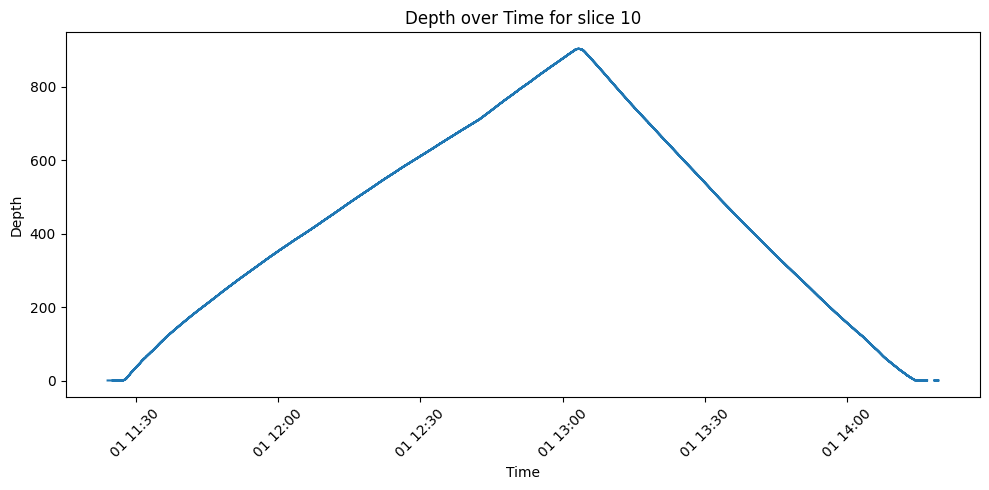

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming gdf is already loaded and contains the required data

# Ensure the time column is in datetime format
gdf['time'] = pd.to_datetime(gdf['time'])

# Find start and end times for each source file
start_times = gdf.groupby('source_file')['time'].first()
end_times = gdf.groupby('source_file')['time'].last()

# Convert to a list if you need to index them
start_times_list = start_times.tolist()
end_times_list = end_times.tolist()

# Set the index 'x' to select which time slice you want to plot
x = 10
# Check if 'x' is within the range of available slices
if x < len(start_times_list) and x < len(end_times_list):
    # Select the subset of data between the start and end times
    mask = (gdf['time'] >= start_times_list[x]) & (gdf['time'] <= end_times_list[x])
    subset = gdf.loc[mask]

    # Plot depth against time
    plt.figure(figsize=(10, 5)) 
    plt.plot(subset['time'], subset['depth'])
    
    # Set plot labels and title
    plt.xlabel('Time')
    plt.ylabel('Depth')
    plt.title(f'Depth over Time for slice {x}')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout so everything fits without overlapping
    plt.show()
else:
    print(f"Index {x} is out of range for the number of slices available.")
